In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.layers import MultiHeadAttention
import numpy as np
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns

In [2]:
tokens = ["I", "am", "a", "student"]
seq_len = len(tokens)
d_model = 16
num_heads = 2
print("토큰 개수:", seq_len)
print("임베딩 차원:", d_model)

토큰 개수: 4
임베딩 차원: 16


In [3]:
def positional_encoding(max_len, d_model):
    pos = np.arange(max_len)[:, np.newaxis]
    i = np.arange(d_model)[np.newaxis, :]
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    angle_rads = pos * angle_rates

    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

def plot_positional_encoding(max_len=30, d_model=16):
    pe = positional_encoding(max_len, d_model).numpy().squeeze()  # shape: (max_len, d_model)

    plt.figure(figsize=(7, 5))
    for i in range(d_model):
        plt.plot(pe[:, i], label=f"dim {i}")
    plt.title(f"Positional Encoding: sin/cos (d_model={d_model})")
    plt.xlabel("Position")
    plt.xticks(range(max_len))
    plt.ylabel("Encoding Value")
    plt.grid(False)

    for x in range(max_len):
        plt.axvline(x=x, color='gray', linestyle='dotted', linewidth=0.8)
    plt.tight_layout()
    plt.show()


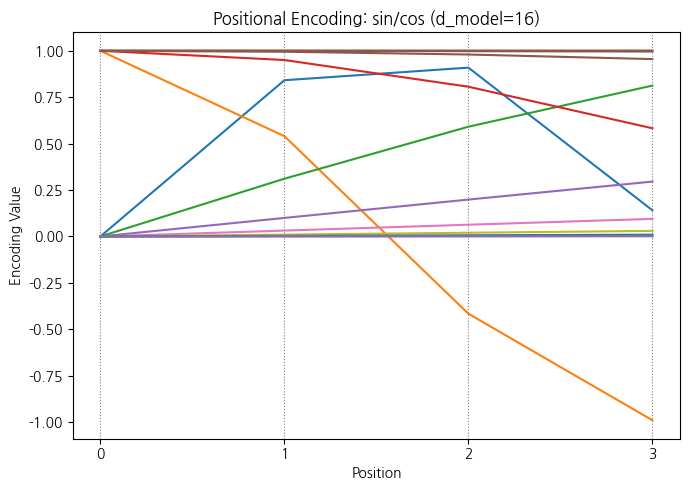

In [4]:
plot_positional_encoding(max_len=seq_len, d_model=d_model)

In [5]:
print("\n--- Multi-Head Attention 예제 ---")

X = tf.Variable(tf.eye(seq_len, d_model) + tf.random.normal((seq_len, d_model), stddev=0.01)) 
print(f"\nX=X[seq_len={seq_len}, d_model={d_model}]:\n")   
X_numpy = X.numpy()  # Tensor → numpy 배열로 변환
for row in X_numpy:
    print("  ".join([f"{val:.2f}" for val in row]))
    
pos_enc = positional_encoding(max_len=seq_len, d_model=d_model)



print("\nPos_Enc:")   
pos_enc_numpy = pos_enc[0].numpy()  # Tensor → numpy 배열로 변환
for row in pos_enc_numpy:
    print("  ".join([f"{val:.2f}" for val in row]))

X_pe = X + pos_enc[0]  # broadcasting
print("\nX_pe+Pos_Enc:")   
Xpe_numpy = X_pe.numpy()  # Tensor → numpy 배열로 변환
for row in Xpe_numpy:
    print("  ".join([f"{val:.2f}" for val in row]))


--- Multi-Head Attention 예제 ---

X=X[seq_len=4, d_model=16]:

1.01  0.00  0.01  -0.01  0.00  0.00  -0.01  -0.02  -0.01  0.01  0.01  -0.00  -0.01  -0.01  -0.01  0.01
0.00  0.99  0.02  0.01  -0.00  -0.01  -0.00  -0.00  0.02  -0.01  0.01  -0.01  -0.02  -0.02  -0.00  0.00
-0.01  -0.00  1.00  -0.00  0.00  0.01  -0.01  -0.01  -0.01  0.00  -0.01  0.00  -0.01  -0.00  0.01  -0.01
0.00  -0.00  0.00  1.00  -0.00  -0.00  -0.00  0.00  0.01  -0.01  0.01  -0.02  -0.00  -0.00  0.01  -0.01

Pos_Enc:
0.00  1.00  0.00  1.00  0.00  1.00  0.00  1.00  0.00  1.00  0.00  1.00  0.00  1.00  0.00  1.00
0.84  0.54  0.31  0.95  0.10  1.00  0.03  1.00  0.01  1.00  0.00  1.00  0.00  1.00  0.00  1.00
0.91  -0.42  0.59  0.81  0.20  0.98  0.06  1.00  0.02  1.00  0.01  1.00  0.00  1.00  0.00  1.00
0.14  -0.99  0.81  0.58  0.30  0.96  0.09  1.00  0.03  1.00  0.01  1.00  0.00  1.00  0.00  1.00

X_pe+Pos_Enc:
1.01  1.00  0.01  0.99  0.00  1.00  -0.01  0.98  -0.01  1.01  0.01  1.00  -0.01  0.99  -0.01  1.01
0.85  1.53  0.3

## 하이퍼파라미터 정의
- d_model = 단어 임베딩 차원 (예 64)
- key_dim = QKV의 차원이다.
- num_heads = 멀티헤드 갯수 
- 반드시 지켜야함.
- d_model = key_dim * num_heads 


In [6]:
# Multi-Head Attention layer
#mha = MultiHeadAttention(num_heads=2, key_dim=2)
from tensorflow.keras.layers import MultiHeadAttention

def create_mha(d_model, num_heads):
    if d_model % num_heads != 0:
        raise ValueError(f"d_model({d_model}) must be divisible by num_heads({num_heads})")
    
    key_dim = d_model // num_heads
    print(f"Creating MultiHeadAttention with key_dim = {key_dim}")
    return MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)

mha = create_mha(d_model, num_heads) 

Creating MultiHeadAttention with key_dim = 8


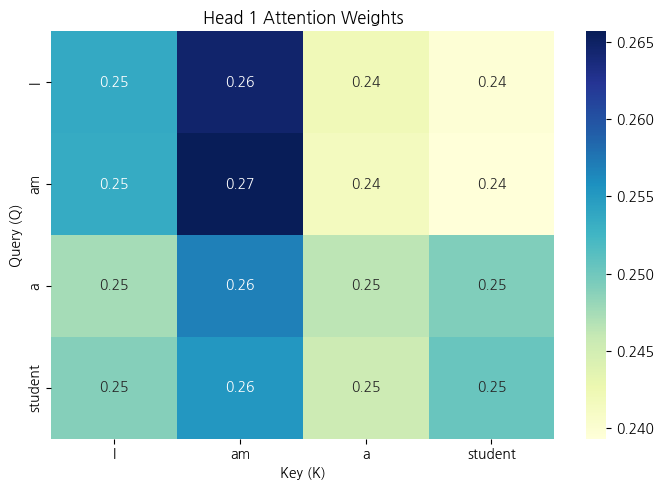

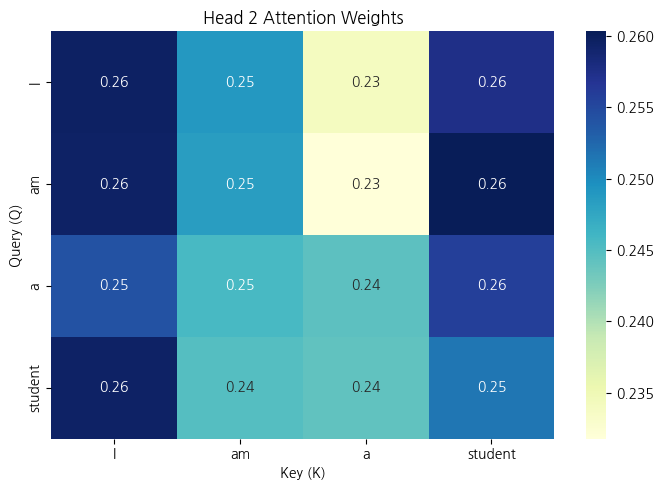

In [7]:
output, weights = mha(query=X_pe[tf.newaxis, ...],
                       key=X_pe[tf.newaxis, ...],
                       value=X_pe[tf.newaxis, ...],
                       return_attention_scores=True)

# 출력 정리
output = tf.squeeze(output, axis=0)
weights = tf.squeeze(weights, axis=0)  

#print("\nMulti-Head Attention Output:\n", tf.round(output * 10) / 10)

for head in range(weights.shape[0]):
    plt.figure(figsize=(7, 5))
    sns.heatmap(weights[head].numpy(), annot=True, fmt=".2f", cmap='YlGnBu',
                xticklabels=tokens, yticklabels=tokens)
    plt.title(f"Head {head+1} Attention Weights")
    plt.xlabel("Key (K)")
    plt.ylabel("Query (Q)")
    plt.tight_layout()
    plt.show()


--- Cross Attention (Encoder-Decoder) 예제 ---


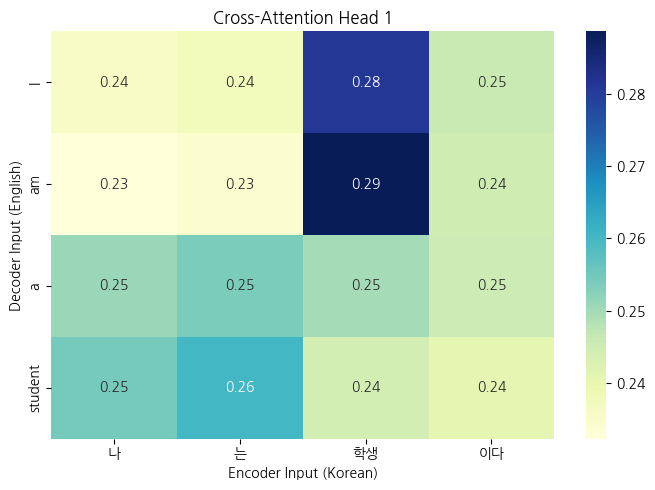

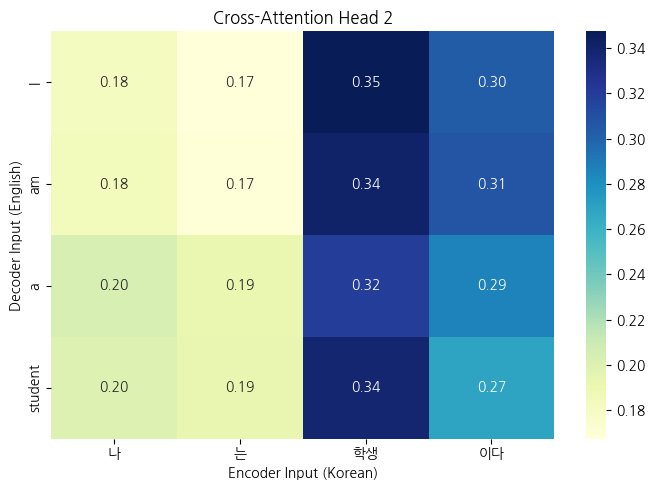


디코더 토큰이 인코더 입력 단어에 어떻게 주의를 집중하는지 확인


In [8]:
# ==== Cross Attention (Encoder-Decoder) 예제 =========
print("\n--- Cross Attention (Encoder-Decoder) 예제 ---")

# Encoder input: "나는 학생이다" (Korean)
encoder_tokens = ["나", "는", "학생", "이다"]
encoder_input = tf.Variable(tf.eye(seq_len, d_model) + tf.random.normal((seq_len, d_model), stddev=0.01)) 
encoder_pe = positional_encoding(max_len=seq_len, d_model=d_model)
encoder_input_pe = encoder_input + encoder_pe[0]

# Decoder input: "I am a student" (English)f
decoder_tokens = ["I", "am", "a", "student"]
decoder_input = tf.Variable(tf.eye(seq_len, d_model) + tf.random.normal((seq_len, d_model), stddev=0.01)) 
decoder_pe = positional_encoding(max_len=seq_len, d_model=d_model)
decoder_input_pe = decoder_input + decoder_pe[0]

# Cross Attention: Decoder's query attends to Encoder's key/value
cross_mha = MultiHeadAttention(num_heads=2, key_dim=2)
cross_output, cross_weights = cross_mha(
    query=decoder_input_pe[tf.newaxis, ...],
    key=encoder_input_pe[tf.newaxis, ...],
    value=encoder_input_pe[tf.newaxis, ...],
    return_attention_scores=True
)

cross_output = tf.squeeze(cross_output, axis=0)
cross_weights = tf.squeeze(cross_weights, axis=0)  # (num_heads, tgt_len, src_len)

for head in range(cross_weights.shape[0]):
    plt.figure(figsize=(7, 5))
    sns.heatmap(cross_weights[head].numpy(), annot=True, fmt=".2f", cmap='YlGnBu',
                xticklabels=encoder_tokens, yticklabels=decoder_tokens)
    plt.title(f"Cross-Attention Head {head+1}")
    plt.xlabel("Encoder Input (Korean)")
    plt.ylabel("Decoder Input (English)")
    plt.tight_layout()
    plt.show()

print("\n디코더 토큰이 인코더 입력 단어에 어떻게 주의를 집중하는지 확인")